# Homework 10 

- INFO 5871-001
- Keke Wu
- Fall 2019

## Imports

If the `WordCloud` line fails, you may need to do `conda install wordcloud` and then restart the kernel to get it to work. Similarly, for `nltk`

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import statsmodels.formula.api as sm
from scipy.special import expit
from statsmodels.graphics.gofplots import qqplot

# Aim

The aim of this homework is to introduce text processing with NLTK and to use logistic regression with the resulting features.

The data set was compiled by the Washington Post. It lists 12,020 false or misleading statements made by President Trump from his inauguration to August 5, 2019.

In [2]:
trump = pd.read_csv('wapo_trumpclaims_export-080519.csv')
print (trump.shape)
trump.head()

(12020, 8)


,id,date,source,topic,claim,analysis,repeated_count,repeated_ids
0,11702,08/05/19,Twitter,Guns,“The Media has a big responsibility to life an...,"There's <a href=""https://psmag.com/news/does-t...",0.0,NaN
1,11703,08/05/19,Twitter,Trade,“China dropped the price of their currency to ...,China's currency dropped to an 11-year low aga...,0.0,NaN
2,11704,08/05/19,Twitter,Trade,“Based on the historic currency manipulation b...,"We calculated that through December, the Trump...",73.0,"11704, 11700, 11166, 11307, 11575, 11629, 1135..."
3,11706,08/05/19,Twitter,Trade,“China is intent on continuing to receive the ...,Trump consistently fails to understand trade d...,166.0,"11706, 11576, 11388, 12211, 11552, 11394, 1218..."
4,12154,08/05/19,Prepared speech,Guns,"“Mental illness and hatred pulls the trigger, ...","The Washington Post <a href=""https://www.washi...",0.0,NaN


## The corpus

Create a corpus by joining together all of the entries in the `claim` column. Some are not strings, so you will have convert to strings. Join using the following syntax:

`' '.join(_list_)`

This will join together all of the string in `_list_`

In [3]:
claimlst = list(trump.claim)
claimstr = [str(item) for item in claimlst]
claims = ' '.join(claimstr)

### Tokenize the claim string, then lower-case

In [4]:
tokens = word_tokenize(claims)
claim_lower = [word.lower() for word in tokens]
len(claim_lower)

502691

## Remove stopwords and punctuation

In [5]:
english_stops = set(stopwords.words('english'))
claim_stops = [word for word in claim_lower if word not in english_stops]
claim_punc = [word for word in claim_stops if word.isalpha()]
claim_punc[0:10]

['media',
 'big',
 'responsibility',
 'life',
 'safety',
 'country',
 'fake',
 'news',
 'contributed',
 'greatly']

### Lemmatize

In [6]:
lemmatizer = WordNetLemmatizer()
claim_lem = [lemmatizer.lemmatize(word) for word in claim_punc]
claim_lem[0:10]

['medium',
 'big',
 'responsibility',
 'life',
 'safety',
 'country',
 'fake',
 'news',
 'contributed',
 'greatly']

### Calculate frequency distribution

Output top 25 words.

In [7]:
fdist = nltk.FreqDist(claim_lem)
for word, frequency in fdist.most_common(25):
    print(u'{};{}' .format(word, frequency))

people;2197
year;1987
country;1814
going;1740
know;1559
billion;1470
want;1306
one;1270
democrat;1219
would;1131
said;1120
many;1077
get;1036
great;1019
like;988
ever;943
think;943
time;925
border;889
job;888
wall;877
right;857
american;854
lot;851
state;841


## Create a word cloud using the top 50 most common words

- get words
- create dictionary
- create wordcloud



In [8]:
top50 = fdist.most_common(50)

In [9]:
top50_dict = {word:freq for word, freq in top50}

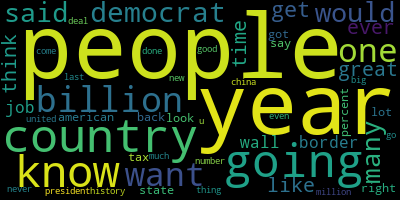

In [10]:
wc_gen = WordCloud()
wc_gen.generate_from_frequencies(top50_dict).to_image()

### Convert top 25 words to features

Use the `convert_to_features` and `feature_to_series` functions from class.

First define `convert_to_features`


In [11]:
def convert_to_features (text, fwords):
    feature_dict = {}
    tokens = word_tokenize(str(text))
    lower = [word.lower() for word in tokens]
    lems = [lemmatizer.lemmatize(word) for word in lower]
    for word in fwords:
        if word in lems:
            feature_dict[word] = 1
        else:
            feature_dict[word] = 0
    return feature_dict

#### Test of `convert_to_features`

Next cell should return a dictionary with these contents:

`{'this': 1, 'test': 1, 'piano': 0, 'cookie': 0}`

In [12]:
convert_to_features("This is a test", ['this', 'test', 'piano', 'cookie'])

{'this': 1, 'test': 1, 'piano': 0, 'cookie': 0}

Then define `feature_to_series`

In [13]:
def feature_to_series (feature_dicts, fword):
    return pd.Series([feature_dict[fword] for feature_dict in feature_dicts])

#### Test of `convert_to_features`

In [14]:
d1 = convert_to_features("This is a test", ['this', 'test', 'piano', 'cookie'])
d2 = convert_to_features("This is a cookie that looks like a piano!", ['this', 'test', 'piano', 'cookie'])

Next cell should return the Series below, because both sentences contain the word 'this'

`0   1
1   1`

In [15]:
feature_to_series([d1, d2], 'this')

0    1
1    1
dtype: int64

Next cell should return this Series, because only the second has the word 'cookie'

`0   0
1   1`

In [16]:
feature_to_series([d1, d2], 'cookie')

0    0
1    1
dtype: int64

### Use the functions to set up features

First, create the dictionary of top25 words. then use `map` to apply it to all of the claims. Then create the series for all the vocabulary words and pass to `pd.DataFrame` to create a data frame. It should look like this:

![](word-features.png)

In [17]:
top25 = fdist.most_common(25)
top25_dict = {word:freq for word, freq in top25}
fwords = list(top25_dict.keys())

In [18]:
claim_dict = trump.claim.map(lambda text: convert_to_features(text, fwords))

In [19]:
claim_series_dict = {fword:feature_to_series(claim_dict, fword) for fword in fwords}
feature_df = pd.DataFrame(claim_series_dict)
print (feature_df.shape)
feature_df.head()

(12020, 25)


,people,year,country,going,know,billion,want,one,democrat,would,...,ever,think,time,border,job,wall,right,american,lot,state
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Combine with original data frame

In [20]:
trump_df = pd.concat([trump, feature_df], axis=1)

In [21]:
trump_df.columns

Index(['id', 'date', 'source', 'topic', 'claim', 'analysis', 'repeated_count',
       'repeated_ids', 'people', 'year', 'country', 'going', 'know', 'billion',
       'want', 'one', 'democrat', 'would', 'said', 'many', 'get', 'great',
       'like', 'ever', 'think', 'time', 'border', 'job', 'wall', 'right',
       'american', 'lot', 'state'],
      dtype='object')

### Create a column for when the topic is immigration

There should bre 2173 claims categorized under immigration


In [22]:
trump_df['immigration'] = np.where(trump_df['topic']=='Immigration', 'True', 'False')
(trump_df['immigration'] == 'True').value_counts()

False    9847
True     2173
Name: immigration, dtype: int64

### Make dummy variables

Use the `immigration` and `source` columns. 

In [23]:
trump_df_dum = pd.get_dummies(trump_df, columns=['immigration','source'])
trump_df_dum.columns

Index(['id', 'date', 'topic', 'claim', 'analysis', 'repeated_count',
       'repeated_ids', 'people', 'year', 'country', 'going', 'know', 'billion',
       'want', 'one', 'democrat', 'would', 'said', 'many', 'get', 'great',
       'like', 'ever', 'think', 'time', 'border', 'job', 'wall', 'right',
       'american', 'lot', 'state', 'immigration_False', 'immigration_True',
       'source_65', 'source_Campaign rally', 'source_Facebook',
       'source_Interview', 'source_Leaked transcript',
       'source_News conference', 'source_Prepared speech', 'source_Remarks',
       'source_Statement', 'source_Twitter', 'source_Vlog'],
      dtype='object')

## Logistic regression to predict the immigration topic in online posts

Only use the Twitter, Facebook, VLog sources

We will use backward-selection via p-value. Stop when all p-values are below 0.05. 

Hint: I had 13 regression models.

### First: Check correlation

Should be no variables above 0.8 or below -0.8. `immigration_True` and `immigration_False` will have correlation -1, but we knew that. 

In [24]:
trump_df_dum = trump_df_dum.drop(['source_65', 'source_Campaign rally','source_Interview', 'source_Leaked transcript','source_News conference', 'source_Prepared speech', 'source_Remarks',
       'source_Statement'], axis=1)
print(trump_df_dum.columns)

Index(['id', 'date', 'topic', 'claim', 'analysis', 'repeated_count',
       'repeated_ids', 'people', 'year', 'country', 'going', 'know', 'billion',
       'want', 'one', 'democrat', 'would', 'said', 'many', 'get', 'great',
       'like', 'ever', 'think', 'time', 'border', 'job', 'wall', 'right',
       'american', 'lot', 'state', 'immigration_False', 'immigration_True',
       'source_Facebook', 'source_Twitter', 'source_Vlog'],
      dtype='object')


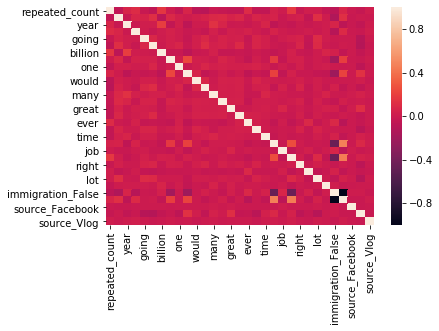

In [25]:
sns.heatmap(trump_df_dum.corr());

In [26]:
(trump_df_dum.corr() > 0.8).sum()

repeated_count       1
people               1
year                 1
country              1
going                1
know                 1
billion              1
want                 1
one                  1
democrat             1
would                1
said                 1
many                 1
get                  1
great                1
like                 1
ever                 1
think                1
time                 1
border               1
job                  1
wall                 1
right                1
american             1
lot                  1
state                1
immigration_False    1
immigration_True     1
source_Facebook      1
source_Twitter       1
source_Vlog          1
dtype: int64

In [27]:
(trump_df_dum.corr() < -0.8).sum()

repeated_count       0
people               0
year                 0
country              0
going                0
know                 0
billion              0
want                 0
one                  0
democrat             0
would                0
said                 0
many                 0
get                  0
great                0
like                 0
ever                 0
think                0
time                 0
border               0
job                  0
wall                 0
right                0
american             0
lot                  0
state                0
immigration_False    1
immigration_True     1
source_Facebook      0
source_Twitter       0
source_Vlog          0
dtype: int64

### Create initial full model

`immigration_True` is the dependent variable

First set of regression results should look like this:

![](reg1-results.png)

In [28]:
reg1 = sm.logit(formula='immigration_True ~ source_Facebook + source_Twitter + source_Vlog + \
                         people + year + country + going + know + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + right + american + lot + state',data = trump_df_dum).fit()

Optimization terminated successfully.
         Current function value: 0.301954
         Iterations 17


In [29]:
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11991
Method:                           MLE   Df Model:                           28
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3610
Time:                        23:54:39   Log-Likelihood:                -3629.5
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.2680      0.054    -42.028      0.000      -2.374      -2.162
source_Facebook  -287.6784    3.2e+62  -8.98e-61      1.000   -6.28e+62    6.28e+62
source_Twitter     -0.8134      0.097     -8.403      0.000      -1.003      -0.624
source_Vlog         0.3056      0.590      0.518      0.604      -0.850       1.461
people              0.8858      0.079     11.263      0.000       0.732       1.040
year               -0.2309      0.098     -2.345      0.019      -0.424      -0.038
country             0.8546      0.076     11.274      0.000       0.706       1.003
going              -0.2711      0.104     -2.601      0.009      -0.475      -0.067
know               -0.0622      0.099     -0.631      0.528      -0.255       0.131
billion            -0.6734      0.140     -4.803      0.000      -0.948      -0.399
want                0.7658      0.096      7.961      0.000       0.577       0.954
one                 0.0948      0.109      0.873      0.383      -0.118       0.308
democrat            1.1953      0.092     13.042      0.000       1.016       1.375
would              -0.1613      0.122     -1.320      0.187      -0.401       0.078
said               -0.4570      0.148     -3.084      0.002      -0.747      -0.167
many               -0.1168      0.125     -0.935      0.350      -0.362       0.128
get                 0.1578      0.116      1.355      0.175      -0.070       0.386
great              -0.6253      0.145     -4.314      0.000      -0.909      -0.341
like                0.1475      0.115      1.285      0.199      -0.078       0.373
ever               -1.4008      0.185     -7.577      0.000      -1.763      -1.038
think              -0.1180      0.125     -0.946      0.344      -0.363       0.127
time               -0.3807      0.137     -2.778      0.005      -0.649      -0.112
border              3.4816      0.123     28.238      0.000       3.240       3.723
job                -0.8321      0.164     -5.084      0.000      -1.153      -0.511
wall                4.4236      0.158     28.082      0.000       4.115       4.732
right              -0.0598      0.127     -0.472      0.637      -0.308       0.188
american           -0.2957      0.149     -1.978      0.048      -0.589      -0.003
lot                -0.0830      0.129     -0.642      0.521      -0.336       0.170
state               0.1410      0.122      1.158      0.247      -0.098       0.380
===================================================================================
"""

### What is the worst (highest) p-value?

In [30]:
reg1.pvalues.idxmax()

'source_Facebook'

### For each subsequent model, indicate what variable you will drop

You can use `idxmax()` or you can eyeball it.

#### 1. Drop 'source_Facebook'

In [31]:
reg2 = sm.logit(formula='immigration_True ~ source_Twitter + source_Vlog + \
                         people + year + country + going + know + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + right + american + lot + state',data = trump_df_dum).fit()
reg2.summary()

Optimization terminated successfully.
         Current function value: 0.302017
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11992
Method:                           MLE   Df Model:                           27
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3609
Time:                        23:54:39   Log-Likelihood:                -3630.2
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2692      0.054    -42.050      0.000      -2.375      -2.163
source_Twitter    -0.8123      0.097     -8.392      0.000      -1.002      -0.623
source_Vlog        0.3064      0.590      0.520      0.603      -0.849       1.462
people             0.8866      0.079     11.273      0.000       0.732       1.041
year              -0.2301      0.098     -2.338      0.019      -0.423      -0.037
country            0.8542      0.076     11.270      0.000       0.706       1.003
going             -0.2707      0.104     -2.597      0.009      -0.475      -0.066
know              -0.0625      0.099     -0.635      0.526      -0.256       0.131
billion           -0.6732      0.140     -4.802      0.000      -0.948      -0.398
want               0.7668      0.096      7.972      0.000       0.578       0.955
one                0.0952      0.109      0.876      0.381      -0.118       0.308
democrat           1.1939      0.092     13.031      0.000       1.014       1.373
would             -0.1618      0.122     -1.325      0.185      -0.401       0.078
said              -0.4572      0.148     -3.085      0.002      -0.748      -0.167
many              -0.1172      0.125     -0.938      0.348      -0.362       0.128
get                0.1579      0.116      1.356      0.175      -0.070       0.386
great             -0.6259      0.145     -4.319      0.000      -0.910      -0.342
like               0.1482      0.115      1.291      0.197      -0.077       0.373
ever              -1.4003      0.185     -7.574      0.000      -1.763      -1.038
think             -0.1174      0.125     -0.941      0.347      -0.362       0.127
time              -0.3803      0.137     -2.775      0.006      -0.649      -0.112
border             3.4823      0.123     28.244      0.000       3.241       3.724
job               -0.8329      0.164     -5.089      0.000      -1.154      -0.512
wall               4.4242      0.158     28.086      0.000       4.115       4.733
right             -0.0592      0.127     -0.468      0.640      -0.307       0.189
american          -0.2948      0.149     -1.972      0.049      -0.588      -0.002
lot               -0.0829      0.129     -0.642      0.521      -0.336       0.170
state              0.1416      0.122      1.163      0.245      -0.097       0.380
==================================================================================
"""

In [32]:
reg2.pvalues.idxmax()

'right'

#### 2.Drop 'right'#

In [33]:
reg3 = sm.logit(formula='immigration_True ~ source_Twitter + source_Vlog + \
                         people + year + country + going + know + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + american + lot + state',data = trump_df_dum).fit()
reg3.summary()

Optimization terminated successfully.
         Current function value: 0.302026
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11993
Method:                           MLE   Df Model:                           26
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3609
Time:                        23:54:39   Log-Likelihood:                -3630.4
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2719      0.054    -42.339      0.000      -2.377      -2.167
source_Twitter    -0.8105      0.097     -8.380      0.000      -1.000      -0.621
source_Vlog        0.3051      0.590      0.517      0.605      -0.852       1.462
people             0.8862      0.079     11.269      0.000       0.732       1.040
year              -0.2304      0.098     -2.341      0.019      -0.423      -0.038
country            0.8542      0.076     11.270      0.000       0.706       1.003
going             -0.2726      0.104     -2.618      0.009      -0.477      -0.069
know              -0.0646      0.098     -0.657      0.511      -0.258       0.128
billion           -0.6723      0.140     -4.797      0.000      -0.947      -0.398
want               0.7655      0.096      7.964      0.000       0.577       0.954
one                0.0946      0.109      0.871      0.384      -0.118       0.308
democrat           1.1946      0.092     13.041      0.000       1.015       1.374
would             -0.1633      0.122     -1.337      0.181      -0.403       0.076
said              -0.4598      0.148     -3.105      0.002      -0.750      -0.170
many              -0.1165      0.125     -0.933      0.351      -0.361       0.128
get                0.1566      0.116      1.346      0.178      -0.071       0.385
great             -0.6266      0.145     -4.325      0.000      -0.910      -0.343
like               0.1472      0.115      1.282      0.200      -0.078       0.372
ever              -1.4014      0.185     -7.578      0.000      -1.764      -1.039
think             -0.1197      0.125     -0.959      0.337      -0.364       0.125
time              -0.3800      0.137     -2.773      0.006      -0.649      -0.111
border             3.4816      0.123     28.242      0.000       3.240       3.723
job               -0.8339      0.164     -5.095      0.000      -1.155      -0.513
wall               4.4224      0.157     28.083      0.000       4.114       4.731
american          -0.2949      0.149     -1.973      0.048      -0.588      -0.002
lot               -0.0832      0.129     -0.644      0.520      -0.337       0.170
state              0.1413      0.122      1.160      0.246      -0.097       0.380
==================================================================================
"""

In [34]:
reg3.pvalues.idxmax()

'source_Vlog'

#### 3.Drop 'source_Vlog'#

In [35]:
reg4 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + know + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + american + lot + state',data = trump_df_dum).fit()
reg4.summary()

Optimization terminated successfully.
         Current function value: 0.302037
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11994
Method:                           MLE   Df Model:                           25
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3609
Time:                        23:54:40   Log-Likelihood:                -3630.5
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2712      0.054    -42.342      0.000      -2.376      -2.166
source_Twitter    -0.8116      0.097     -8.393      0.000      -1.001      -0.622
people             0.8861      0.079     11.266      0.000       0.732       1.040
year              -0.2300      0.098     -2.337      0.019      -0.423      -0.037
country            0.8552      0.076     11.288      0.000       0.707       1.004
going             -0.2725      0.104     -2.617      0.009      -0.477      -0.068
know              -0.0657      0.098     -0.668      0.504      -0.259       0.127
billion           -0.6724      0.140     -4.798      0.000      -0.947      -0.398
want               0.7653      0.096      7.961      0.000       0.577       0.954
one                0.0945      0.109      0.870      0.384      -0.118       0.307
democrat           1.1950      0.092     13.047      0.000       1.016       1.375
would             -0.1641      0.122     -1.344      0.179      -0.403       0.075
said              -0.4599      0.148     -3.105      0.002      -0.750      -0.170
many              -0.1164      0.125     -0.932      0.351      -0.361       0.128
get                0.1568      0.116      1.348      0.178      -0.071       0.385
great             -0.6271      0.145     -4.329      0.000      -0.911      -0.343
like               0.1483      0.115      1.293      0.196      -0.077       0.373
ever              -1.4014      0.185     -7.577      0.000      -1.764      -1.039
think             -0.1206      0.125     -0.967      0.334      -0.365       0.124
time              -0.3790      0.137     -2.766      0.006      -0.648      -0.110
border             3.4821      0.123     28.249      0.000       3.241       3.724
job               -0.8330      0.164     -5.089      0.000      -1.154      -0.512
wall               4.4232      0.157     28.091      0.000       4.115       4.732
american          -0.2959      0.149     -1.980      0.048      -0.589      -0.003
lot               -0.0827      0.129     -0.640      0.522      -0.336       0.171
state              0.1415      0.122      1.163      0.245      -0.097       0.380
==================================================================================
"""

In [36]:
reg4.pvalues.idxmax()

'lot'

#### 4.Drop 'lot'#

In [37]:
reg5 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + know + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + american + state',data = trump_df_dum).fit()
reg5.summary()

Optimization terminated successfully.
         Current function value: 0.302054
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11995
Method:                           MLE   Df Model:                           24
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3608
Time:                        23:54:40   Log-Likelihood:                -3630.7
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2748      0.053    -42.624      0.000      -2.379      -2.170
source_Twitter    -0.8065      0.096     -8.372      0.000      -0.995      -0.618
people             0.8802      0.078     11.269      0.000       0.727       1.033
year              -0.2302      0.098     -2.339      0.019      -0.423      -0.037
country            0.8558      0.076     11.297      0.000       0.707       1.004
going             -0.2772      0.104     -2.668      0.008      -0.481      -0.074
know              -0.0699      0.098     -0.712      0.476      -0.262       0.123
billion           -0.6729      0.140     -4.801      0.000      -0.948      -0.398
want               0.7655      0.096      7.965      0.000       0.577       0.954
one                0.0959      0.109      0.883      0.377      -0.117       0.309
democrat           1.1966      0.092     13.069      0.000       1.017       1.376
would             -0.1654      0.122     -1.356      0.175      -0.405       0.074
said              -0.4593      0.148     -3.103      0.002      -0.749      -0.169
many              -0.1163      0.125     -0.931      0.352      -0.361       0.128
get                0.1557      0.116      1.338      0.181      -0.072       0.384
great             -0.6280      0.145     -4.336      0.000      -0.912      -0.344
like               0.1482      0.115      1.291      0.197      -0.077       0.373
ever              -1.3996      0.185     -7.570      0.000      -1.762      -1.037
think             -0.1231      0.125     -0.987      0.324      -0.367       0.121
time              -0.3808      0.137     -2.779      0.005      -0.649      -0.112
border             3.4817      0.123     28.250      0.000       3.240       3.723
job               -0.8323      0.164     -5.086      0.000      -1.153      -0.512
wall               4.4122      0.156     28.202      0.000       4.106       4.719
american          -0.2937      0.149     -1.966      0.049      -0.587      -0.001
state              0.1423      0.122      1.169      0.242      -0.096       0.381
==================================================================================
"""

In [38]:
reg5.pvalues.idxmax()

'know'

#### 5.Drop 'know'#

In [39]:
reg6 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + one + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + american + state',data = trump_df_dum).fit()
reg6.summary()

Optimization terminated successfully.
         Current function value: 0.302075
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11996
Method:                           MLE   Df Model:                           23
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3608
Time:                        23:54:40   Log-Likelihood:                -3630.9
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2806      0.053    -43.205      0.000      -2.384      -2.177
source_Twitter    -0.8010      0.096     -8.341      0.000      -0.989      -0.613
people             0.8741      0.078     11.259      0.000       0.722       1.026
year              -0.2308      0.098     -2.345      0.019      -0.424      -0.038
country            0.8575      0.076     11.324      0.000       0.709       1.006
going             -0.2806      0.104     -2.703      0.007      -0.484      -0.077
billion           -0.6729      0.140     -4.801      0.000      -0.948      -0.398
want               0.7637      0.096      7.952      0.000       0.576       0.952
one                0.0926      0.108      0.854      0.393      -0.120       0.305
democrat           1.1976      0.092     13.084      0.000       1.018       1.377
would             -0.1663      0.122     -1.363      0.173      -0.405       0.073
said              -0.4667      0.148     -3.161      0.002      -0.756      -0.177
many              -0.1188      0.125     -0.952      0.341      -0.363       0.126
get                0.1529      0.116      1.316      0.188      -0.075       0.381
great             -0.6311      0.145     -4.359      0.000      -0.915      -0.347
like               0.1411      0.114      1.234      0.217      -0.083       0.365
ever              -1.3982      0.185     -7.561      0.000      -1.761      -1.036
think             -0.1267      0.125     -1.017      0.309      -0.371       0.118
time              -0.3826      0.137     -2.793      0.005      -0.651      -0.114
border             3.4814      0.123     28.257      0.000       3.240       3.723
job               -0.8309      0.164     -5.076      0.000      -1.152      -0.510
wall               4.4111      0.156     28.202      0.000       4.105       4.718
american          -0.2901      0.149     -1.943      0.052      -0.583       0.003
state              0.1417      0.122      1.165      0.244      -0.097       0.380
==================================================================================
"""

In [40]:
reg6.pvalues.idxmax()

'one'

#### 6.Drop 'one'#

In [41]:
reg7 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + would + said + \
                         many + get + great + like + ever + think + time + \
                         border + job + wall + american + state',data = trump_df_dum).fit()
reg7.summary()

Optimization terminated successfully.
         Current function value: 0.302105
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11997
Method:                           MLE   Df Model:                           22
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3607
Time:                        23:54:40   Log-Likelihood:                -3631.3
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2742      0.052    -43.557      0.000      -2.377      -2.172
source_Twitter    -0.8047      0.096     -8.393      0.000      -0.993      -0.617
people             0.8755      0.078     11.279      0.000       0.723       1.028
year              -0.2281      0.098     -2.320      0.020      -0.421      -0.035
country            0.8578      0.076     11.328      0.000       0.709       1.006
going             -0.2809      0.104     -2.706      0.007      -0.484      -0.077
billion           -0.6744      0.140     -4.815      0.000      -0.949      -0.400
want               0.7643      0.096      7.958      0.000       0.576       0.953
democrat           1.1976      0.092     13.086      0.000       1.018       1.377
would             -0.1628      0.122     -1.335      0.182      -0.402       0.076
said              -0.4591      0.147     -3.114      0.002      -0.748      -0.170
many              -0.1167      0.125     -0.935      0.350      -0.361       0.128
get                0.1575      0.116      1.357      0.175      -0.070       0.385
great             -0.6284      0.145     -4.341      0.000      -0.912      -0.345
like               0.1432      0.114      1.253      0.210      -0.081       0.367
ever              -1.3946      0.185     -7.544      0.000      -1.757      -1.032
think             -0.1237      0.125     -0.993      0.321      -0.368       0.120
time              -0.3803      0.137     -2.778      0.005      -0.649      -0.112
border             3.4788      0.123     28.249      0.000       3.237       3.720
job               -0.8306      0.164     -5.076      0.000      -1.151      -0.510
wall               4.4101      0.156     28.196      0.000       4.104       4.717
american          -0.2926      0.149     -1.959      0.050      -0.585    9.29e-05
state              0.1445      0.122      1.188      0.235      -0.094       0.383
==================================================================================
"""

In [42]:
reg7.pvalues.idxmax()

'many'

#### 7.Drop 'many'#

In [43]:
reg8 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + would + said + \
                         get + great + like + ever + think + time + \
                         border + job + wall + american + state',data = trump_df_dum).fit()
reg8.summary()

Optimization terminated successfully.
         Current function value: 0.302142
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11998
Method:                           MLE   Df Model:                           21
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3607
Time:                        23:54:40   Log-Likelihood:                -3631.7
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2772      0.052    -43.689      0.000      -2.379      -2.175
source_Twitter    -0.8085      0.096     -8.440      0.000      -0.996      -0.621
people             0.8681      0.077     11.241      0.000       0.717       1.019
year              -0.2396      0.098     -2.454      0.014      -0.431      -0.048
country            0.8561      0.076     11.309      0.000       0.708       1.004
going             -0.2829      0.104     -2.727      0.006      -0.486      -0.080
billion           -0.6765      0.140     -4.832      0.000      -0.951      -0.402
want               0.7650      0.096      7.968      0.000       0.577       0.953
democrat           1.1975      0.092     13.087      0.000       1.018       1.377
would             -0.1632      0.122     -1.339      0.181      -0.402       0.076
said              -0.4597      0.147     -3.118      0.002      -0.749      -0.171
get                0.1567      0.116      1.351      0.177      -0.071       0.384
great             -0.6313      0.145     -4.362      0.000      -0.915      -0.348
like               0.1397      0.114      1.223      0.221      -0.084       0.364
ever              -1.3943      0.185     -7.537      0.000      -1.757      -1.032
think             -0.1200      0.124     -0.965      0.335      -0.364       0.124
time              -0.3864      0.137     -2.825      0.005      -0.655      -0.118
border             3.4758      0.123     28.251      0.000       3.235       3.717
job               -0.8317      0.164     -5.083      0.000      -1.152      -0.511
wall               4.4113      0.156     28.205      0.000       4.105       4.718
american          -0.2906      0.149     -1.947      0.052      -0.583       0.002
state              0.1382      0.121      1.138      0.255      -0.100       0.376
==================================================================================
"""

In [44]:
reg8.pvalues.idxmax()

'think'

#### 8.Drop 'think'#

In [45]:
reg9 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + would + said + \
                         get + great + like + ever + time + \
                         border + job + wall + american + state',data = trump_df_dum).fit()
reg9.summary()

Optimization terminated successfully.
         Current function value: 0.302182
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    11999
Method:                           MLE   Df Model:                           20
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3606
Time:                        23:54:41   Log-Likelihood:                -3632.2
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2829      0.052    -44.064      0.000      -2.384      -2.181
source_Twitter    -0.8024      0.096     -8.393      0.000      -0.990      -0.615
people             0.8621      0.077     11.199      0.000       0.711       1.013
year              -0.2394      0.098     -2.452      0.014      -0.431      -0.048
country            0.8545      0.076     11.292      0.000       0.706       1.003
going             -0.2876      0.104     -2.777      0.005      -0.491      -0.085
billion           -0.6767      0.140     -4.834      0.000      -0.951      -0.402
want               0.7640      0.096      7.961      0.000       0.576       0.952
democrat           1.1981      0.091     13.095      0.000       1.019       1.377
would             -0.1693      0.122     -1.391      0.164      -0.408       0.069
said              -0.4636      0.147     -3.145      0.002      -0.752      -0.175
get                0.1541      0.116      1.328      0.184      -0.073       0.381
great             -0.6345      0.145     -4.383      0.000      -0.918      -0.351
like               0.1363      0.114      1.194      0.232      -0.087       0.360
ever              -1.3978      0.185     -7.551      0.000      -1.761      -1.035
time              -0.3861      0.137     -2.823      0.005      -0.654      -0.118
border             3.4764      0.123     28.262      0.000       3.235       3.717
job               -0.8314      0.164     -5.081      0.000      -1.152      -0.511
wall               4.4105      0.156     28.216      0.000       4.104       4.717
american          -0.2869      0.149     -1.923      0.055      -0.579       0.006
state              0.1366      0.121      1.125      0.261      -0.101       0.375
==================================================================================
"""

In [46]:
reg9.pvalues.idxmax()

'state'

#### 9.Drop 'state'#

In [47]:
reg10 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + would + said + \
                         get + great + like + ever + time + \
                         border + job + wall + american',data = trump_df_dum).fit()
reg10.summary()

Optimization terminated successfully.
         Current function value: 0.302233
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    12000
Method:                           MLE   Df Model:                           19
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3605
Time:                        23:54:41   Log-Likelihood:                -3632.8
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2738      0.051    -44.488      0.000      -2.374      -2.174
source_Twitter    -0.8009      0.096     -8.379      0.000      -0.988      -0.614
people             0.8628      0.077     11.211      0.000       0.712       1.014
year              -0.2384      0.098     -2.442      0.015      -0.430      -0.047
country            0.8561      0.076     11.316      0.000       0.708       1.004
going             -0.2846      0.104     -2.749      0.006      -0.488      -0.082
billion           -0.6710      0.140     -4.794      0.000      -0.945      -0.397
want               0.7640      0.096      7.959      0.000       0.576       0.952
democrat           1.1925      0.091     13.056      0.000       1.013       1.372
would             -0.1698      0.122     -1.394      0.163      -0.408       0.069
said              -0.4665      0.147     -3.165      0.002      -0.755      -0.178
get                0.1522      0.116      1.312      0.190      -0.075       0.380
great             -0.6312      0.145     -4.358      0.000      -0.915      -0.347
like               0.1364      0.114      1.196      0.232      -0.087       0.360
ever              -1.3932      0.185     -7.534      0.000      -1.756      -1.031
time              -0.3867      0.137     -2.827      0.005      -0.655      -0.119
border             3.4777      0.123     28.265      0.000       3.237       3.719
job               -0.8303      0.164     -5.075      0.000      -1.151      -0.510
wall               4.4009      0.156     28.215      0.000       4.095       4.707
american          -0.2887      0.149     -1.936      0.053      -0.581       0.004
==================================================================================
"""

In [48]:
reg10.pvalues.idxmax()

'like'

#### 10.Drop 'like'#

In [49]:
reg11 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + would + said + \
                         get + great + ever + time + \
                         border + job + wall + american',data = trump_df_dum).fit()
reg11.summary()

Optimization terminated successfully.
         Current function value: 0.302291
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    12001
Method:                           MLE   Df Model:                           18
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3603
Time:                        23:54:41   Log-Likelihood:                -3633.5
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2665      0.051    -44.701      0.000      -2.366      -2.167
source_Twitter    -0.8046      0.096     -8.421      0.000      -0.992      -0.617
people             0.8694      0.077     11.329      0.000       0.719       1.020
year              -0.2373      0.098     -2.431      0.015      -0.429      -0.046
country            0.8593      0.076     11.367      0.000       0.711       1.007
going             -0.2815      0.104     -2.719      0.007      -0.484      -0.079
billion           -0.6732      0.140     -4.809      0.000      -0.948      -0.399
want               0.7626      0.096      7.948      0.000       0.575       0.951
democrat           1.1945      0.091     13.084      0.000       1.016       1.373
would             -0.1640      0.122     -1.348      0.178      -0.402       0.074
said              -0.4601      0.147     -3.126      0.002      -0.749      -0.172
get                0.1588      0.116      1.371      0.170      -0.068       0.386
great             -0.6321      0.145     -4.367      0.000      -0.916      -0.348
ever              -1.3838      0.184     -7.503      0.000      -1.745      -1.022
time              -0.3843      0.137     -2.809      0.005      -0.652      -0.116
border             3.4794      0.123     28.267      0.000       3.238       3.721
job               -0.8308      0.164     -5.080      0.000      -1.151      -0.510
wall               4.3974      0.156     28.201      0.000       4.092       4.703
american          -0.2923      0.149     -1.961      0.050      -0.584      -0.000
==================================================================================
"""

In [50]:
reg11.pvalues.idxmax()

'would'

#### 11.Drop 'would'#

In [51]:
reg12 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + said + \
                         get + great + ever + time + \
                         border + job + wall + american',data = trump_df_dum).fit()
reg12.summary()

Optimization terminated successfully.
         Current function value: 0.302369
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    12002
Method:                           MLE   Df Model:                           17
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3602
Time:                        23:54:41   Log-Likelihood:                -3634.5
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2736      0.050    -45.071      0.000      -2.372      -2.175
source_Twitter    -0.8051      0.096     -8.429      0.000      -0.992      -0.618
people             0.8672      0.077     11.302      0.000       0.717       1.018
year              -0.2397      0.098     -2.456      0.014      -0.431      -0.048
country            0.8596      0.076     11.372      0.000       0.711       1.008
going             -0.2833      0.103     -2.739      0.006      -0.486      -0.081
billion           -0.6715      0.140     -4.803      0.000      -0.946      -0.397
want               0.7611      0.096      7.941      0.000       0.573       0.949
democrat           1.1830      0.091     13.029      0.000       1.005       1.361
said              -0.4714      0.147     -3.205      0.001      -0.760      -0.183
get                0.1524      0.116      1.317      0.188      -0.074       0.379
great             -0.6419      0.145     -4.436      0.000      -0.926      -0.358
ever              -1.3852      0.185     -7.505      0.000      -1.747      -1.023
time              -0.3881      0.137     -2.837      0.005      -0.656      -0.120
border             3.4775      0.123     28.281      0.000       3.237       3.719
job               -0.8324      0.164     -5.086      0.000      -1.153      -0.512
wall               4.3946      0.156     28.179      0.000       4.089       4.700
american          -0.2942      0.149     -1.973      0.048      -0.586      -0.002
==================================================================================
"""

In [52]:
reg12.pvalues.idxmax()

'get'

#### 12.Drop 'get'#

In [53]:
reg13 = sm.logit(formula='immigration_True ~ source_Twitter + \
                         people + year + country + going + billion + want + democrat + said + \
                         great + ever + time + \
                         border + job + wall + american',data = trump_df_dum).fit()
reg13.summary()

Optimization terminated successfully.
         Current function value: 0.302440
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       immigration_True   No. Observations:                12020
Model:                          Logit   Df Residuals:                    12003
Method:                           MLE   Df Model:                           16
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.3600
Time:                        23:54:41   Log-Likelihood:                -3635.3
converged:                       True   LL-Null:                       -5680.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2667      0.050    -45.218      0.000      -2.365      -2.168
source_Twitter    -0.8062      0.096     -8.439      0.000      -0.993      -0.619
people             0.8771      0.076     11.490      0.000       0.728       1.027
year              -0.2300      0.097     -2.363      0.018      -0.421      -0.039
country            0.8572      0.076     11.346      0.000       0.709       1.005
going             -0.2752      0.103     -2.667      0.008      -0.477      -0.073
billion           -0.6748      0.140     -4.830      0.000      -0.949      -0.401
want               0.7699      0.096      8.049      0.000       0.582       0.957
democrat           1.1857      0.091     13.059      0.000       1.008       1.364
said              -0.4688      0.147     -3.188      0.001      -0.757      -0.181
great             -0.6382      0.145     -4.412      0.000      -0.922      -0.355
ever              -1.3896      0.185     -7.529      0.000      -1.751      -1.028
time              -0.3863      0.137     -2.824      0.005      -0.654      -0.118
border             3.4758      0.123     28.276      0.000       3.235       3.717
job               -0.8290      0.163     -5.072      0.000      -1.149      -0.509
wall               4.3947      0.156     28.182      0.000       4.089       4.700
american          -0.2975      0.149     -1.996      0.046      -0.590      -0.005
==================================================================================
"""

In [54]:
reg13.pvalues > 0.05

Intercept         False
source_Twitter    False
people            False
year              False
country           False
going             False
billion           False
want              False
democrat          False
said              False
great             False
ever              False
time              False
border            False
job               False
wall              False
american          False
dtype: bool

## Interpretation

### Compare the AIC of the first and last regression models

Did it improve?

In [55]:
reg1.aic

7316.965118798256

In [56]:
reg13.aic

7304.647751887904

_Yes, the aic got lower which means it improved._

### Examining the parameters answer the following questions?

In [57]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
model_odds = pd.DataFrame(np.exp(reg13.params), columns= ['OR'])
model_odds['p-value']= reg13.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(reg13.conf_int())
model_odds

,OR,p-value,2.5%,97.5%
Intercept,0.103650,0.000000e+00,0.093950,0.114350
source_Twitter,0.446542,3.211717e-17,0.370287,0.538500
people,2.404015,1.475335e-30,2.069945,2.792001
year,0.794570,1.813305e-02,0.656590,0.961547
country,2.356523,7.764156e-30,2.032186,2.732623
going,0.759410,7.648956e-03,0.620362,0.929624
billion,0.509274,1.367714e-06,0.387281,0.669693
want,2.159478,8.372359e-16,1.790316,2.604760
democrat,3.272844,5.669798e-39,2.739307,3.910298
said,0.625730,1.434164e-03,0.469023,0.834794


What word has the most positive impact on the log-odds of a false statement being about immigration?

_'wall'_

What word has the most negative impact on the log-odds of a false statement being about immigration?

_'ever'_

Does Trump make false statements about immigration more often on twitter or on other venues

In [58]:
expit(reg1.params['Intercept']+reg1.params['source_Twitter'])

0.043880147411586405

In [59]:
expit(reg1.params['Intercept']+reg1.params['source_Facebook'])

1.1964412149866041e-126

In [60]:
expit(reg1.params['Intercept']+reg1.params['source_Vlog'])

0.12320722934332391

### Using the `predict()` function

What would the model predict about a statement made somewhere other than Twitter that included the words: country, american, job, time, democrat, people, want? 

Create a dictionary with all the features in the model (1s and 0s) and pass it to the `predict` function.

In [61]:
reg13.params

Intercept        -2.266740
source_Twitter   -0.806222
people            0.877140
year             -0.229954
country           0.857187
going            -0.275213
billion          -0.674770
want              0.769866
democrat          1.185659
said             -0.468837
great            -0.638204
ever             -1.389617
time             -0.386255
border            3.475794
job              -0.828953
wall              4.394697
american         -0.297528
dtype: float64

In [62]:
feature_predict = {"source_Twitter":0,
                   "people":1,
                   "year":0,
                   "country":1,
                   "going":0,
                   "billion":0,
                   "want":1,
                   "democrat":1,
                   "said":0,
                   "great":0,
                   "ever":0,
                   "time":1,
                   "border":0,
                   "job":1,
                   "wall":0,
                   "american":1   
                 }

In [63]:
reg13.predict(feature_predict)

0    0.477609
dtype: float64

The statement is most likely about immigration. Hint: value should be around 2/3.

### Conditions

Show the distribution of the residuals in a distplot and a QQ plot. What problems do you see?

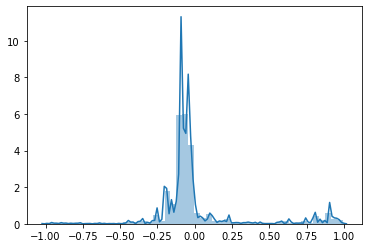

In [64]:
sns.distplot(reg13.resid_response);

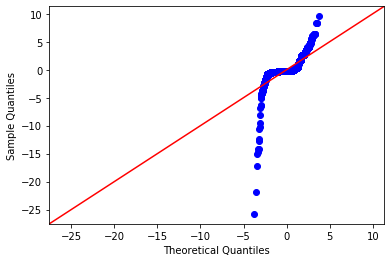

In [65]:
p = qqplot(reg13.resid_pearson,line='45',fit='True');

_The data were not normally distributed, which indicates the model didn't fit the data very well._

### Pick any two word features

Create two violin plots with the residuals for each value: 1 (word present) and 0 (word not present). Is there significant heteroskedasticity?

#### Word 1

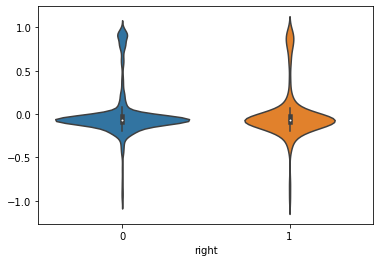

In [66]:
sns.violinplot(x = trump_df_dum.right,y = reg13.resid_response);

Pretty good

#### Word 2:

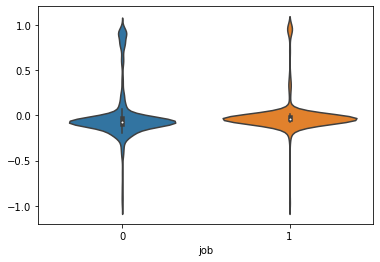

In [67]:
g = sns.violinplot(x=trump_df_dum.job,y=reg13.resid_response)

More heteroskedasticity. Residuals are worse when the word is present.